# **주요 내용**
*  각 layer에 대한 출력값을 시각화

In [1]:
import tensorflow as tf
tf.__version__

'2.2.0-rc2'

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15478871108951463519, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 15598257519935119443
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7540632658708350933
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15701463552
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7539450353559604718
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [3]:
import platform
platform.platform()

'Linux-4.19.104+-x86_64-with-Ubuntu-18.04-bionic'

In [4]:
!nvidia-smi

Sun Apr  5 14:59:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    32W / 250W |    353MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**파일 압축 해제 (드라이브에는 *.zip 파일 형식으로 저장되어 있음)**

In [6]:
import os

pcm_path = "./pcm_dataset"
wav_path = "./wav_dataset"

# mkdir
if not os.path.exists(pcm_path):
    os.mkdir(pcm_path)

if not os.path.exists(wav_path):
    os.mkdir(wav_path)

# unzip with quite mode (-q options)
!unzip -q "/content/drive/My Drive/ETRI/9_voice_download_4_Korean_English_by_Korean_part2.zip" -d "./pcm_dataset"

print(os.listdir(pcm_path)[:5])
print(len(os.listdir(pcm_path)))

['GSF04923PEY0', 'GSM02434AGS0', 'GSM06235BJH0', 'I4F02821YRR0', 'GSF03732JJH0']
50


***.pcm to *.wav**

In [7]:
import wave

for i, folder_path in enumerate(sorted(os.listdir(pcm_path))): # sorted!!!
    file_list = os.listdir(os.path.join(pcm_path, folder_path)) # label's path
    file_list_pcm = [files for files in file_list if files.endswith(".pcm")] # *.pcm files

    for j, file_path in enumerate(sorted(file_list_pcm)): # sorted!!!
        with open(os.path.join(pcm_path, folder_path, file_path), "rb") as pcm_file:
            pcm_data = pcm_file.read()
        # save as {label}_{features}.wav format
        with wave.open(os.path.join(wav_path, "{}_{}.wav".format(i, j)), 'wb') as wav_file:
            wav_file.setparams((1, 2, 16000, 0, 'NONE', 'NONE')) # 16kHz, mono channel
            wav_file.writeframes(pcm_data)

# print samples
print(os.listdir(wav_path)[:5])
print(len(os.listdir(wav_path)))

['49_70.wav', '48_70.wav', '19_92.wav', '20_68.wav', '0_94.wav']
5000


In [0]:
import numpy as np

num_labels = 50
num_features = 100
sr = 16000
duration = 1

train_rate = 0.8
num_train_data = int(num_features * train_rate) # 80

select_train_data = [True] * num_train_data + [False] * (num_features - num_train_data)
select_test_data = [False] * num_train_data + [True] * (num_features - num_train_data)

# naming
save_train_data_name = 'train_data'
save_train_labels_name = 'train_labels'

save_test_data_name = 'test_data'
save_test_labels_name = 'test_labels'

**train data, test data로 구분하여 numpy 저장 (*.npz)**

In [17]:
# save features as *.npz format

from scipy.io import wavfile

data = np.zeros((num_labels * num_features, duration * sr))
labels = np.zeros((num_labels * num_features))

for i in range(num_labels):
    for j in range(num_features):
        file_name = "{}_{}.wav".format(i, j)
        sample_rate, samples = wavfile.read(os.path.join(wav_path, file_name))
        
        # extract 1 sec (i.e. 'duration * sr' length) of each files
        start = int(len(samples)//2 - duration * sample_rate / 2)
        end = int(len(samples)//2 + duration * sample_rate / 2)
        
        data[i * num_features + j] = samples[start:end]
        labels[i * num_features + j] = i

train_data = data[select_train_data * num_labels]
train_labels = labels[select_train_data * num_labels]

test_data = data[select_test_data * num_labels]
test_labels = labels[select_test_data * num_labels]

# save *.npy        
np.save("./" + save_train_data_name, train_data)
np.save("./" + save_train_labels_name, train_labels)

np.save("./" + save_test_data_name, test_data)
np.save("./" + save_test_labels_name, test_labels)

print("train_data.shape: {}, train_labels.shape: {}".format(train_data.shape, train_labels.shape))
print("test_data.shape: {}, test_labels.shape: {}".format(test_data.shape, test_labels.shape))

train_data.shape: (4000, 16000), train_labels.shape: (4000,)
test_data.shape: (1000, 16000), test_labels.shape: (1000,)


**train data, validation data 분할 및 전처리 (normalization)**

In [19]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

random_state = 1234
len_data = train_data.shape[1] # 16000
test_size = 0.2

X_train, X_val, Y_train, Y_val = train_test_split(train_data, train_labels,
                                                  test_size = test_size,
                                                  random_state = random_state) # fixed

x_train = X_train.reshape(len(X_train), len_data, 1)
x_val = X_val.reshape(len(X_val), len_data, 1) 

y_train = to_categorical(Y_train)
y_val = to_categorical(Y_val)

# standarization
mean = x_train.mean()
x_train -= mean
std = x_train.std()
x_train /= std

x_val -= mean
x_val /= std 

print("test_size: {}, random_state: {}\n".format(test_size, random_state))
print('x_train.shape: {}, y_train.shape: {}'.format(x_train.shape, y_train.shape))
print('x_val.shape: {}, y_val.shape: {}'.format(x_val.shape, y_val.shape))

test_size: 0.2, random_state: 1234

x_train.shape: (3200, 16000, 1), y_train.shape: (3200, 50)
x_val.shape: (800, 16000, 1), y_val.shape: (800, 50)


**Build Model (GlobalMaxPooling1D, GlobalAveragePooling1D를 사용한 두 개의 모델 비교)**

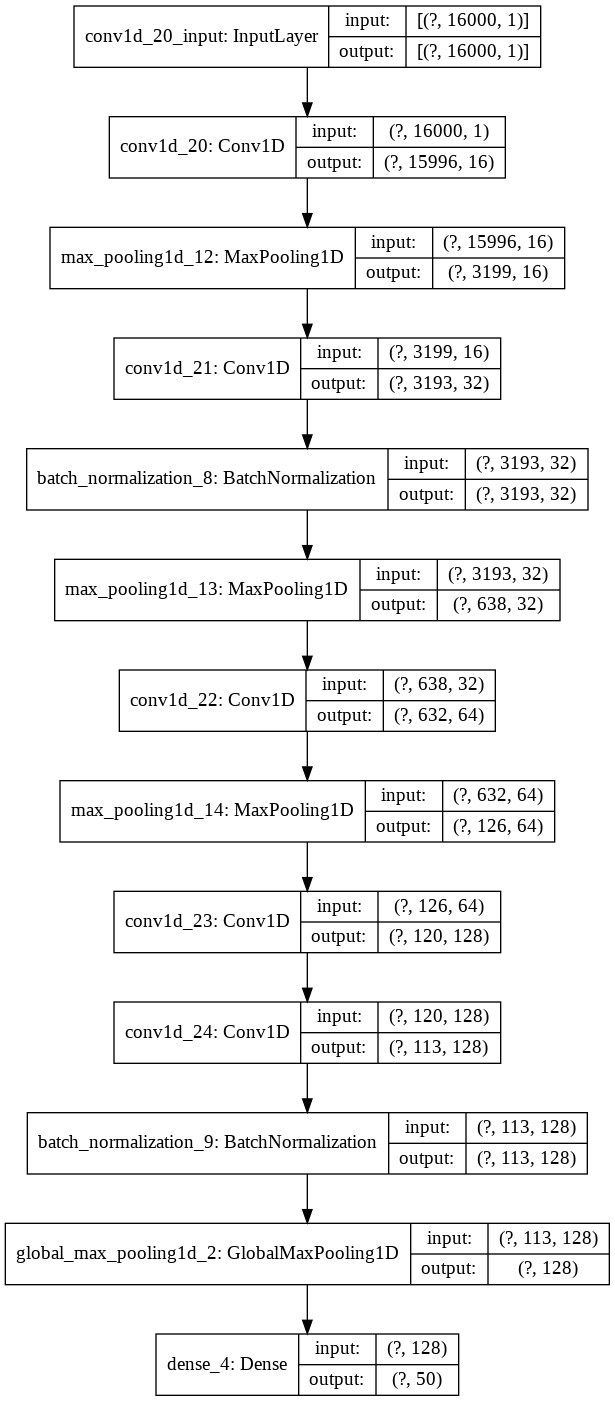

In [31]:
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model

model_1 = Sequential()
model_1.add(layers.Conv1D(16, 5, activation = 'relu', input_shape = (sr * duration, 1)))
model_1.add(layers.MaxPooling1D(5))

model_1.add(layers.Conv1D(32, 7, activation = 'relu'))
model_1.add(layers.BatchNormalization())
model_1.add(layers.MaxPooling1D(5))

model_1.add(layers.Conv1D(64, 7, activation = 'relu'))
model_1.add(layers.MaxPooling1D(5))

model_1.add(layers.Conv1D(128, 7, activation = 'relu'))
model_1.add(layers.Conv1D(128, 8, activation = 'relu'))
model_1.add(layers.BatchNormalization())
model_1.add(layers.GlobalMaxPooling1D())
# model_1.add(layers.GlobalAveragePooling1D())

model_1.add(layers.Dense(num_labels, activation = 'softmax'))

model_1.compile(optimizer = 'rmsprop',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

# model.summary()
plot_model(model_1, show_shapes = True, to_file = 'model_1.png')

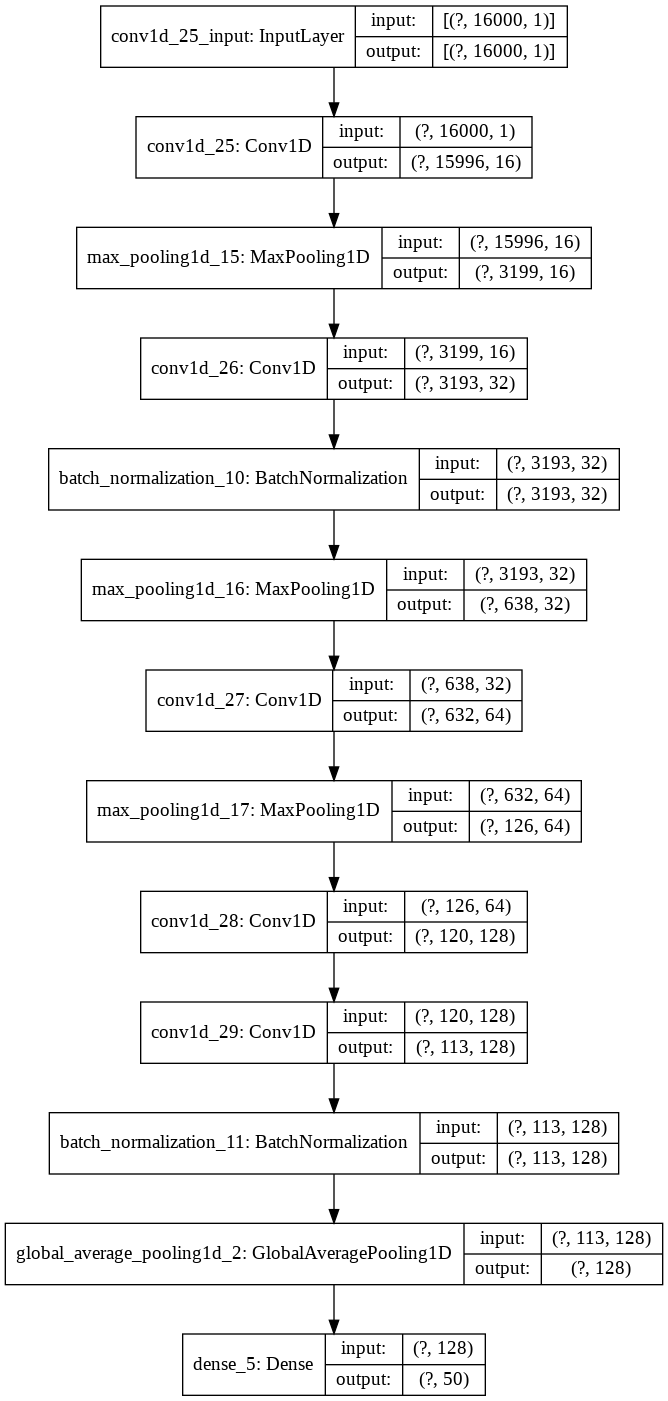

In [32]:
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model

model_2 = Sequential()
model_2.add(layers.Conv1D(16, 5, activation = 'relu', input_shape = (sr * duration, 1)))
model_2.add(layers.MaxPooling1D(5))

model_2.add(layers.Conv1D(32, 7, activation = 'relu'))
model_2.add(layers.BatchNormalization())
model_2.add(layers.MaxPooling1D(5))

model_2.add(layers.Conv1D(64, 7, activation = 'relu'))
model_2.add(layers.MaxPooling1D(5))

model_2.add(layers.Conv1D(128, 7, activation = 'relu'))
model_2.add(layers.Conv1D(128, 8, activation = 'relu'))
model_2.add(layers.BatchNormalization())
# model_2.add(layers.GlobalMaxPooling1D())
model_2.add(layers.GlobalAveragePooling1D())

model_2.add(layers.Dense(num_labels, activation = 'softmax'))

model_2.compile(optimizer = 'rmsprop',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

# model.summary()
plot_model(model_2, show_shapes = True, to_file = 'model_2.png')

**모델 훈련 및 저장**

In [33]:
from datetime import datetime

batch_size = 80
epochs = 100

# model 1
history_1 = model_1.fit(x_train, y_train,
                        validation_data = (x_val, y_val),
                        epochs = epochs,
                        batch_size = batch_size,
                        verbose = 1) # 1 → 훈련과정 보기, 0 → 훈련과정 생략

save_model_path = "/content/drive/My Drive/models" # save to my drive
if not os.path.exists(save_model_path):
    os.mkdir(save_model_path)

model_1.save(os.path.join(save_model_path, "{}.h5".format(datetime.today().strftime("%Y_%m_%d_%H_%M_%S"))))

# model 2
history_2 = model_2.fit(x_train, y_train,
                        validation_data = (x_val, y_val),
                        epochs = epochs,
                        batch_size = batch_size,
                        verbose = 1) # 1 → 훈련과정 보기, 0 → 훈련과정 생략

model_2.save(os.path.join(save_model_path, "{}.h5".format(datetime.today().strftime("%Y_%m_%d_%H_%M_%S"))))

Epoch 1/100
40/40 [==============================] - 1s 29ms/step - loss: 3.7758 - accuracy: 0.1366 - val_loss: 3.6227 - val_accuracy: 0.1187
Epoch 2/100
40/40 [==============================] - 1s 26ms/step - loss: 2.3303 - accuracy: 0.3534 - val_loss: 3.3258 - val_accuracy: 0.1400
Epoch 3/100
40/40 [==============================] - 1s 26ms/step - loss: 1.5954 - accuracy: 0.5462 - val_loss: 3.3695 - val_accuracy: 0.1063
Epoch 4/100
40/40 [==============================] - 1s 26ms/step - loss: 1.1231 - accuracy: 0.6703 - val_loss: 3.1263 - val_accuracy: 0.1625
Epoch 5/100
40/40 [==============================] - 1s 26ms/step - loss: 0.8124 - accuracy: 0.7550 - val_loss: 2.9114 - val_accuracy: 0.1988
Epoch 6/100
40/40 [==============================] - 1s 26ms/step - loss: 0.5533 - accuracy: 0.8356 - val_loss: 2.5851 - val_accuracy: 0.2400
Epoch 7/100
40/40 [==============================] - 1s 26ms/step - loss: 0.4337 - accuracy: 0.8716 - val_loss: 2.4981 - val_accuracy: 0.2713
Epoch 

**히스토리 출력**

In [34]:
print(history_1.history.keys())
print(history_2.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


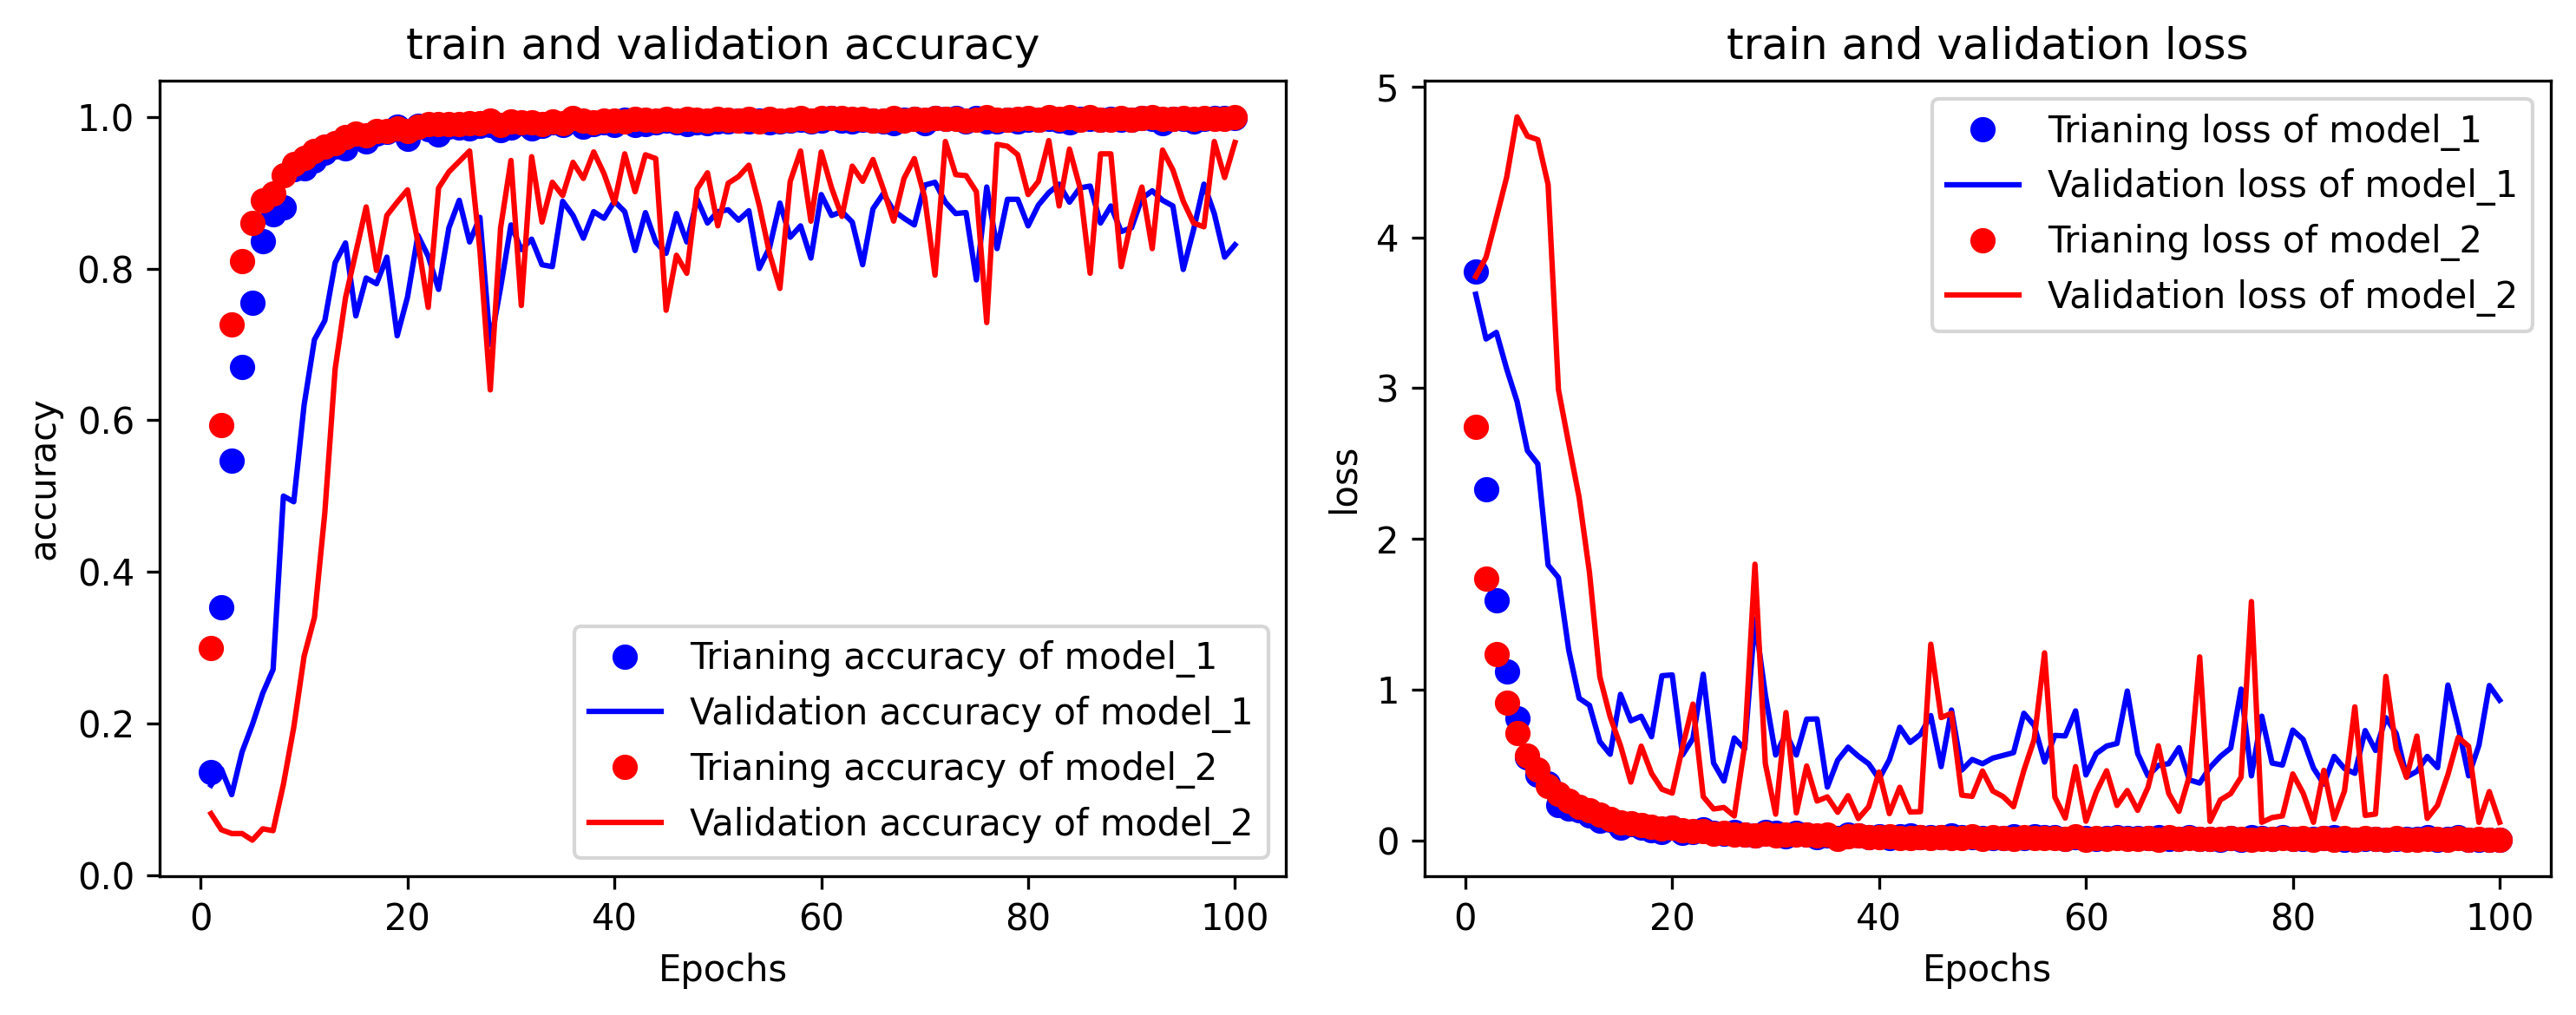

In [38]:
import matplotlib.pyplot as plt

acc_1 = history_1.history['accuracy']
val_acc_1 = history_1.history['val_accuracy']
loss_1 = history_1.history['loss']
val_loss_1 = history_1.history['val_loss']

acc_2 = history_2.history['accuracy']
val_acc_2 = history_2.history['val_accuracy']
loss_2 = history_2.history['loss']
val_loss_2 = history_2.history['val_loss']

fig = plt.figure(figsize = (10, 4), facecolor = 'white', dpi = 300)

# accuracy
plt.subplot(1, 2, 1)

plt.plot(range(1, epochs + 1), acc_1, 'bo', label = 'Trianing accuracy of model_1')
plt.plot(range(1, epochs + 1), val_acc_1, 'b', label = 'Validation accuracy of model_1')
plt.plot(range(1, epochs + 1), acc_2, 'ro', label = 'Trianing accuracy of model_2')
plt.plot(range(1, epochs + 1), val_acc_2, 'r', label = 'Validation accuracy of model_2')
plt.title('train and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

# loss
plt.subplot(1, 2, 2)

plt.plot(range(1, epochs + 1), loss_1, 'bo', label = 'Trianing loss of model_1')
plt.plot(range(1, epochs + 1), val_loss_1, 'b', label = 'Validation loss of model_1')
plt.plot(range(1, epochs + 1), loss_2, 'ro', label = 'Trianing loss of model_2')
plt.plot(range(1, epochs + 1), val_loss_2, 'r', label = 'Validation loss of model_2')
plt.title('train and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

plt.tight_layout()
plt.show()

**test data를 통해 모델 최종 평가 (field test)**

In [41]:
# reshaping
del test_data, test_labels

test_data = np.load(save_test_data_name + ".npy")
test_labels = np.load(save_test_labels_name + ".npy")

test_data = test_data.reshape(len(test_data), len_data, 1)
test_labels = to_categorical(test_labels)

# standarization
test_data -= mean
test_data /= std 

print('test_data.shape: {}, test_labels.shape: {}'.format(test_data.shape, test_labels.shape))

test_data.shape: (1000, 16000, 1), test_labels.shape: (1000, 50)


In [46]:
results_1 = model_1.evaluate(test_data, test_labels, batch_size = batch_size)
results_2 = model_2.evaluate(test_data, test_labels, batch_size = batch_size)

print('[model_1] test loss, test acc:', results_1, "- GlobalMaxPooling1D()")
print('[model_2] test loss, test acc:', results_2, "- GlobalAveragePooling1D()")

13/13 [==============================] - 0s 9ms/step - loss: 0.1362 - accuracy: 0.9630
[model_1] test loss, test acc: [0.8182364106178284, 0.8389999866485596] - GlobalMaxPooling1D()
[model_2] test loss, test acc: [0.1362481266260147, 0.9629999995231628] - GlobalAveragePooling1D()


**훈련에 사용되지 않은 임의의 test sample 선정 및 내용 확인 (0_80.wav file)**

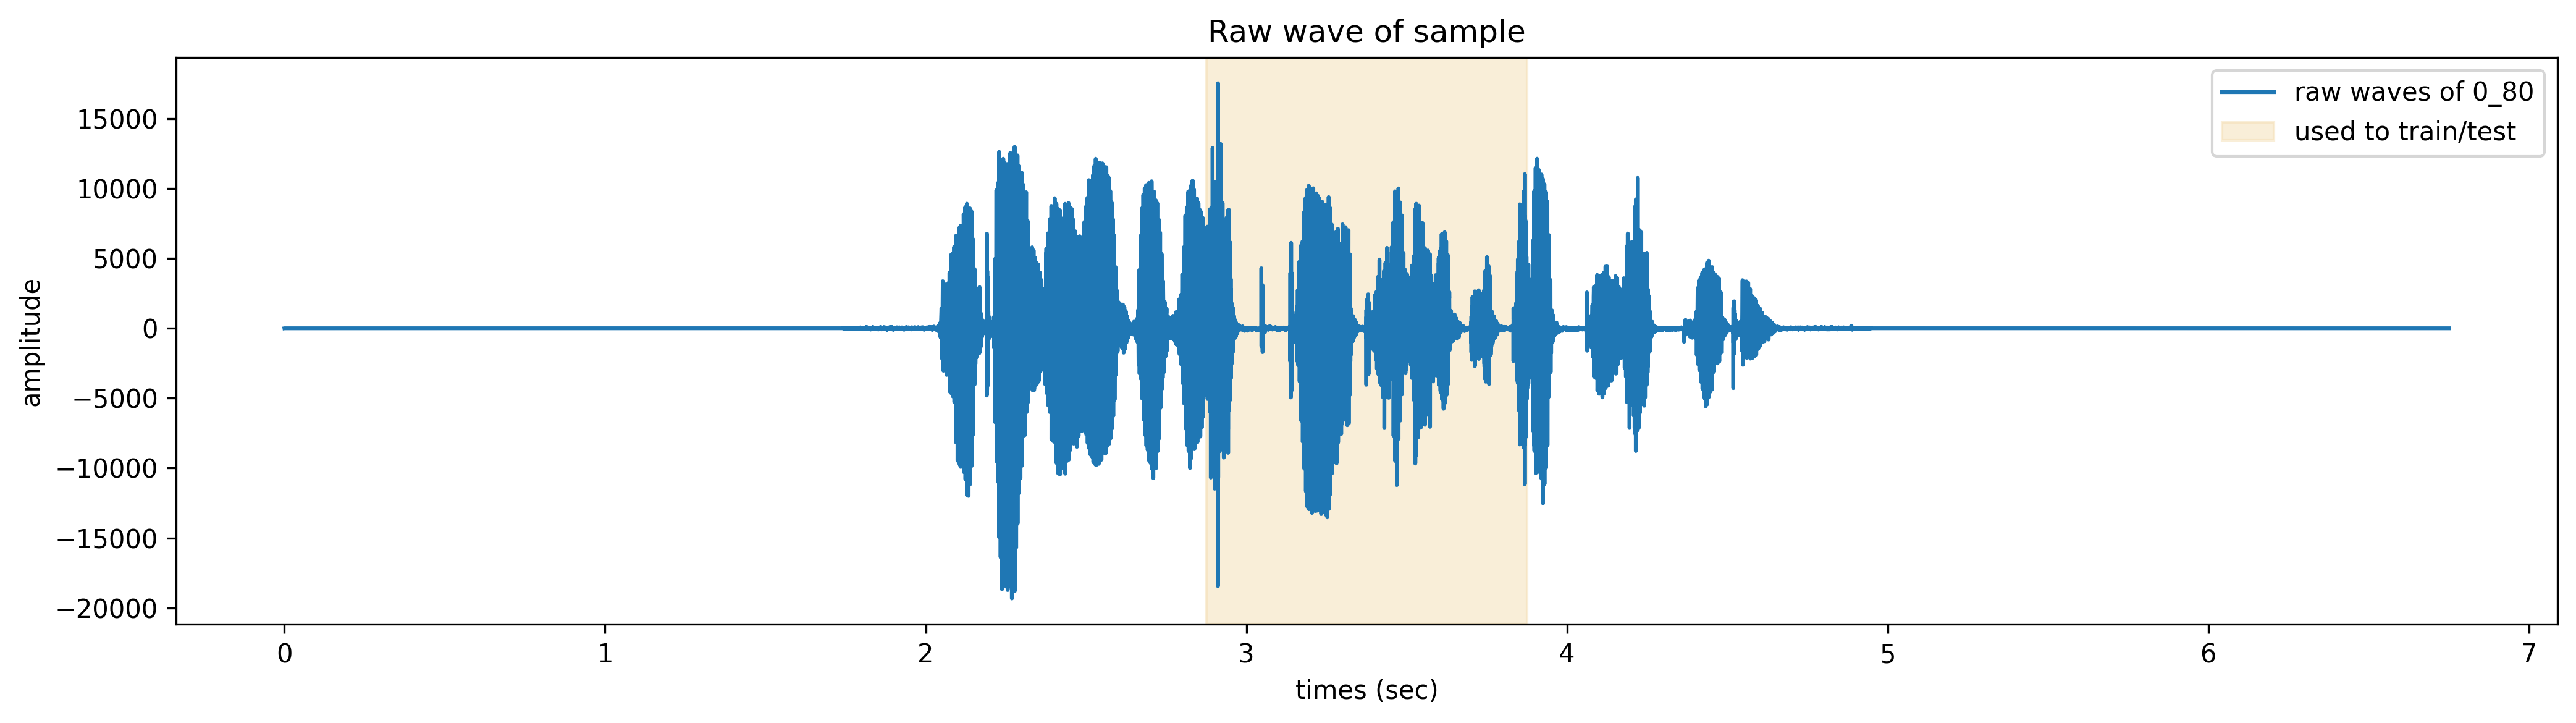

In [47]:
sample_rate, samples = wavfile.read(os.path.join(wav_path, "0_80.wav")) # one of test data

fig = plt.figure(figsize = (14, 4), facecolor = 'white', dpi = 300)

plt.plot(np.arange(0, len(samples)/sample_rate, 1/sample_rate), samples, label = "raw waves of {}_{}".format(0, 80))

start = int(len(samples)//2 - duration * sample_rate / 2)
end = int(len(samples)//2 + duration * sample_rate / 2)
plt.axvspan(start / sample_rate, end / sample_rate, alpha = 0.5, color = "wheat", label = "used to train/test")

plt.title('Raw wave of sample')
plt.xlabel('times (sec)')
plt.ylabel('amplitude')

plt.legend()
plt.tight_layout()

**1초 구간을 자른 뒤 전처리 진행 (normalization, 텐서화)**

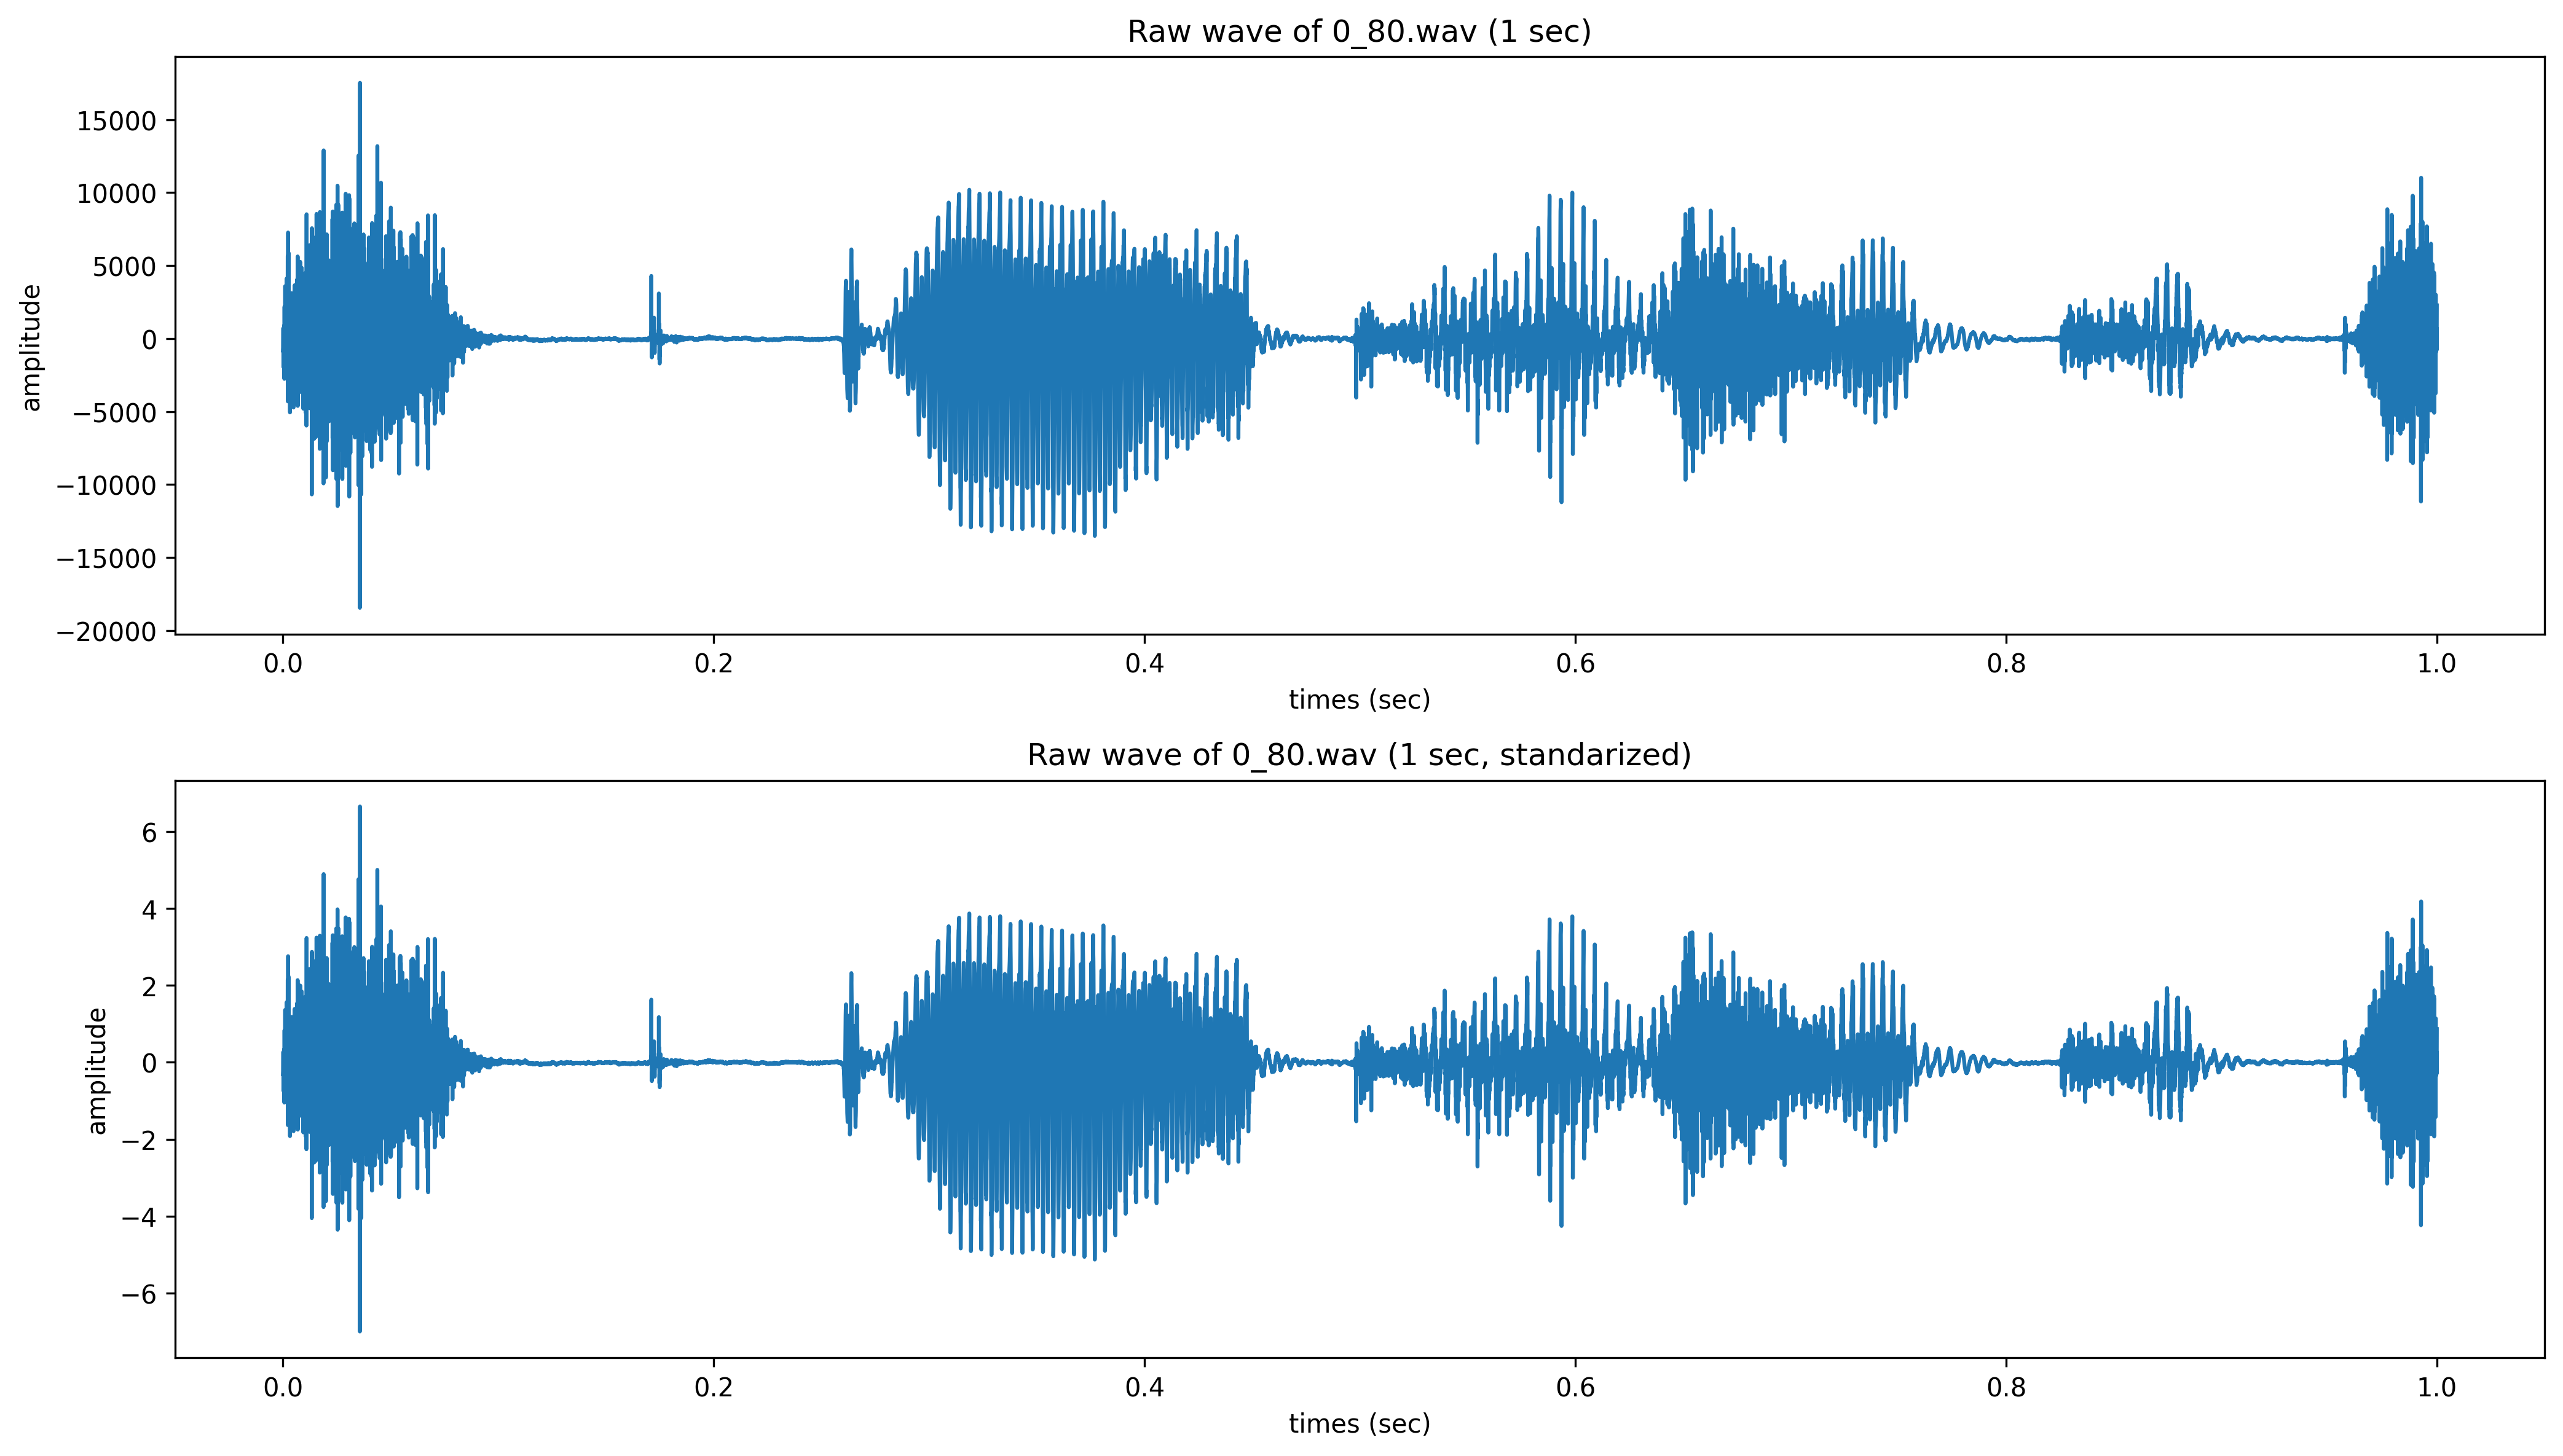

In [53]:
fig = plt.figure(figsize = (14, 8), facecolor = 'white', dpi = 300)

# plot un-standarized samples
plt.subplot(2, 1, 1)
plt.plot(np.arange(0, 1, 1/sr), samples[start:end])

plt.title('Raw wave of {}_{}.wav (1 sec)'.format(0, 80))
plt.xlabel('times (sec)')
plt.ylabel('amplitude')

# plot standarized samples
plt.subplot(2, 1, 2)

resized_samples = np.array(samples[start:end], dtype = 'float64')
resized_samples -= mean
resized_samples /= std

plt.plot(np.arange(0, 1, 1/sr), resized_samples)

plt.title('Raw wave of {}_{}.wav (1 sec, standarized)'.format(0, 80))
plt.xlabel('times (sec)')
plt.ylabel('amplitude')

plt.tight_layout()

In [54]:
test_sample = resized_samples.reshape(1, len(resized_samples), 1)

print(test_sample.shape)

(1, 16000, 1)


**test sample이 필터를 거치면서 어떤 식으로 변화하는지 (각 단계의 출력값을 통해) 확인**

**(단, 앞의 훈련 결과를 근거로 model_2에 대해 확인함)**

In [0]:
from tensorflow.keras import models

layer_outputs = [layer.output for layer in model_2.layers]
activation_model = models.Model(inputs = model_2.input, outputs = layer_outputs)

In [0]:
activations = activation_model.predict(test_sample)

In [68]:
layer_names = np.array([])
for layer in model_2.layers:
    layer_names = np.append(layer_names, layer.name)

print(layer_names)

['conv1d_25' 'max_pooling1d_15' 'conv1d_26' 'batch_normalization_10'
 'max_pooling1d_16' 'conv1d_27' 'max_pooling1d_17' 'conv1d_28' 'conv1d_29'
 'batch_normalization_11' 'global_average_pooling1d_2' 'dense_5']


**첫 번째 layer (conv1d_25)의 output shape 및 2번째 필터에 대한 test data의 출력값 확인**

In [58]:
first_layer_activation = activations[0]

print(first_layer_activation.shape)

(1, 15996, 16)


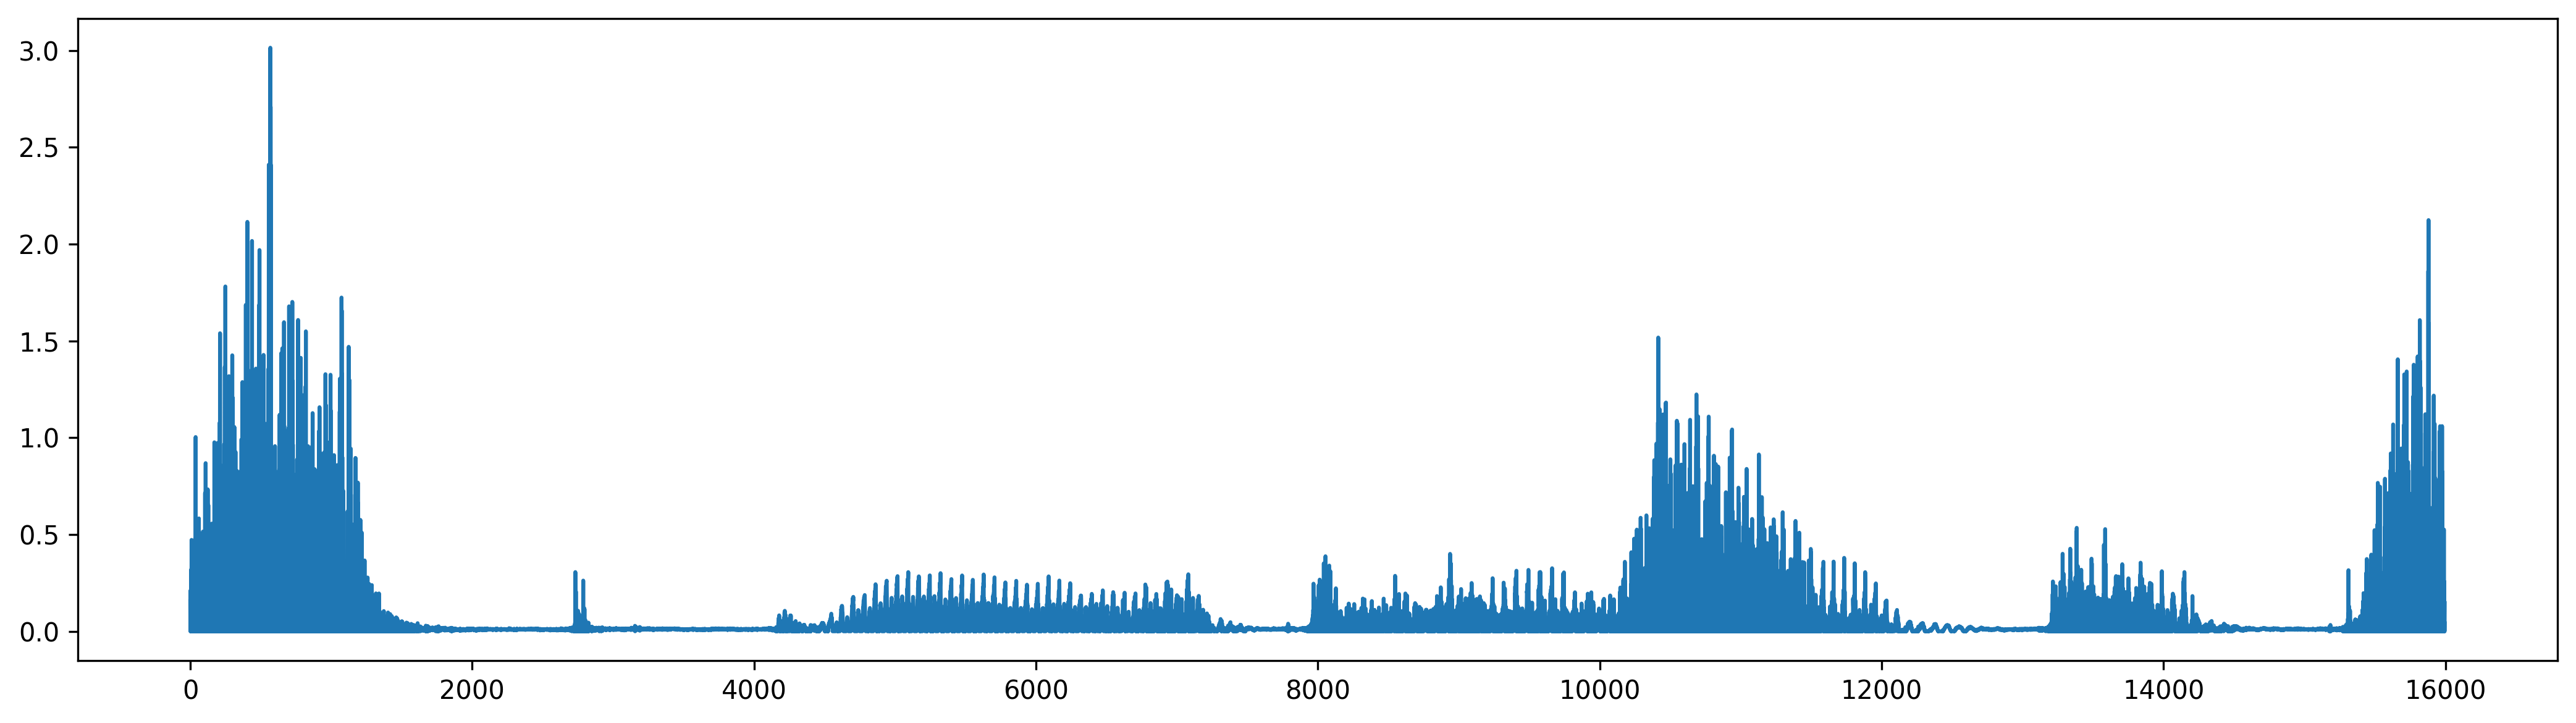

In [59]:
fig = plt.figure(figsize = (14, 4), facecolor = 'white', dpi = 300)

plt.plot(np.arange(0, first_layer_activation.shape[1], 1),
         first_layer_activation[0, :, 1]) # 16개의 필터중 2번째 필터에 대한 출력값 확인
plt.tight_layout()

**두 번째 layer(max_pooling1d_15)의 output shape 및 2번째 필터에 대한 test data의 출력값 확인**

In [60]:
second_layer_activation = activations[1]

print(second_layer_activation.shape)

(1, 3199, 16)


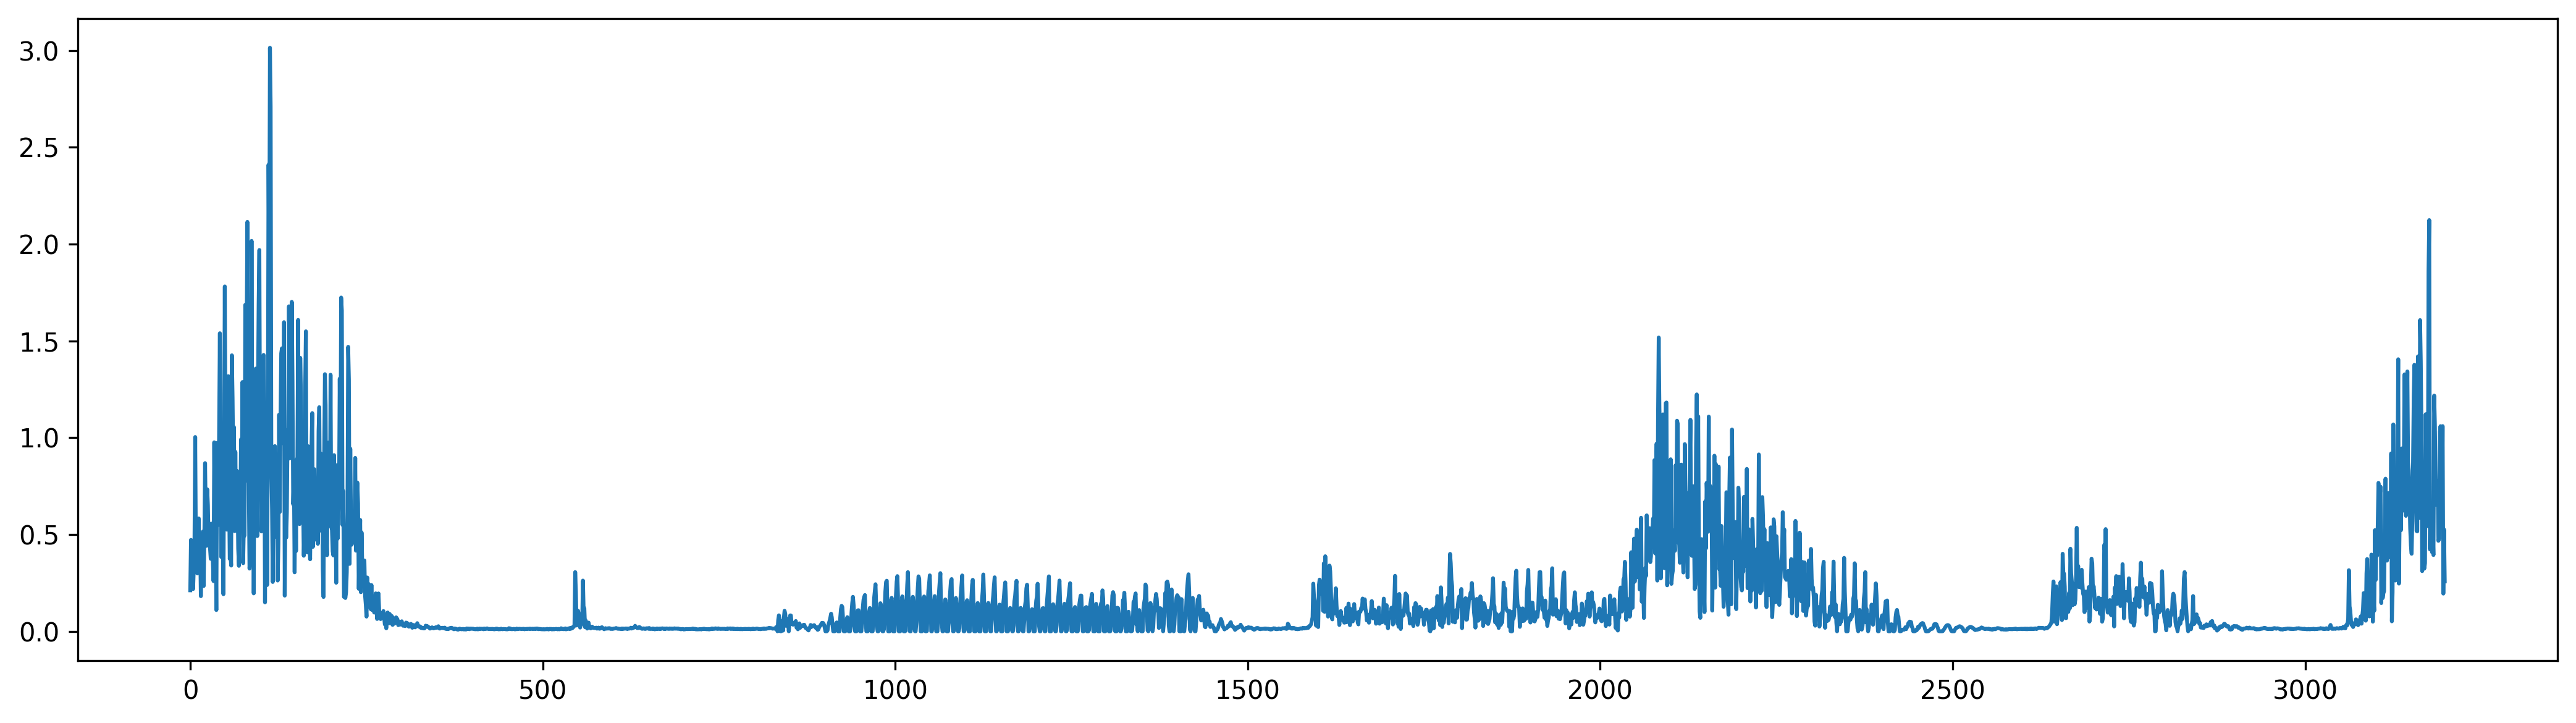

In [61]:
fig = plt.figure(figsize = (14, 4), facecolor = 'white', dpi = 300)

plt.plot(np.arange(0, second_layer_activation.shape[1], 1),
         second_layer_activation[0, :, 1])
plt.tight_layout()

**다섯 번째 layer(max_pooling1d_16)의 output shape 및 2번째 필터에 대한 test data의 출력값 확인**

In [63]:
fifth_layer_activation = activations[4]

print(fifth_layer_activation.shape)

(1, 638, 32)


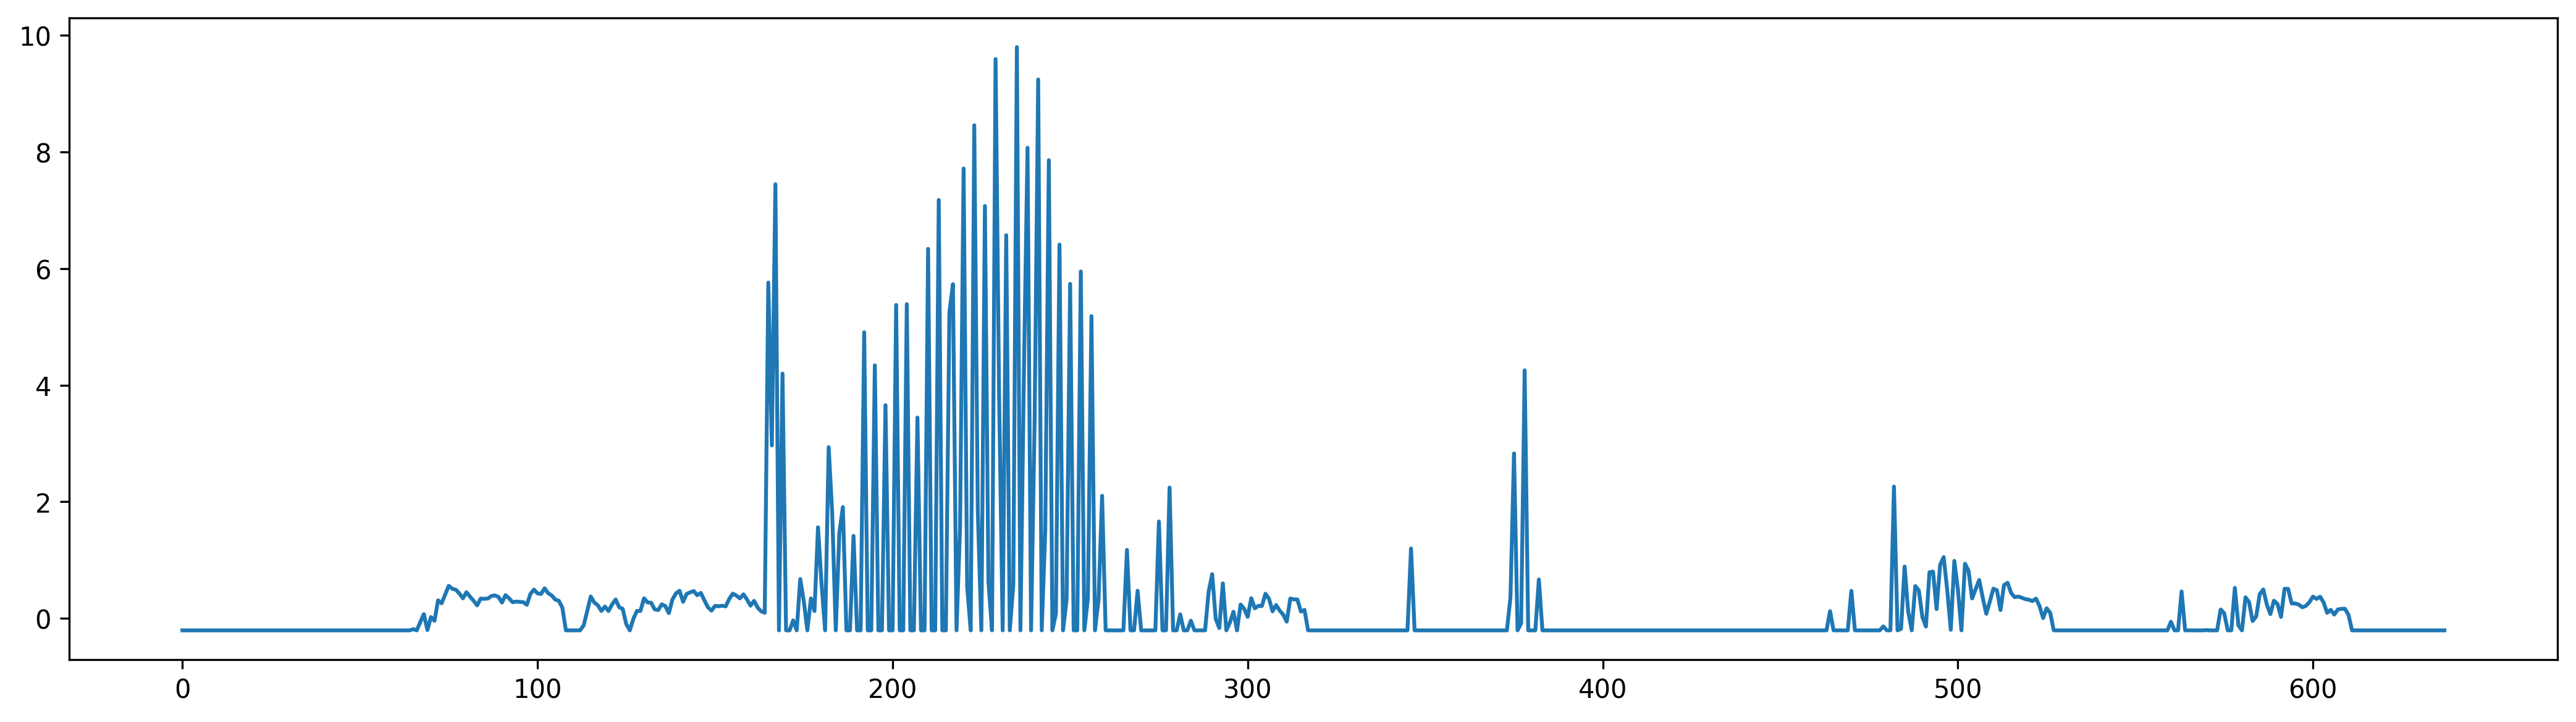

In [69]:
fig = plt.figure(figsize = (14, 4), facecolor = 'white', dpi = 300)

plt.plot(np.arange(0, fifth_layer_activation.shape[1], 1),
         fifth_layer_activation[0, :, 1])
plt.tight_layout()

**최종 layer(dense_5)의 output shape 및 2번째 필터에 대한 test data의 출력값 확인**

In [70]:
final_layer_activation = activations[-1]

print(final_layer_activation.shape)

(1, 50)


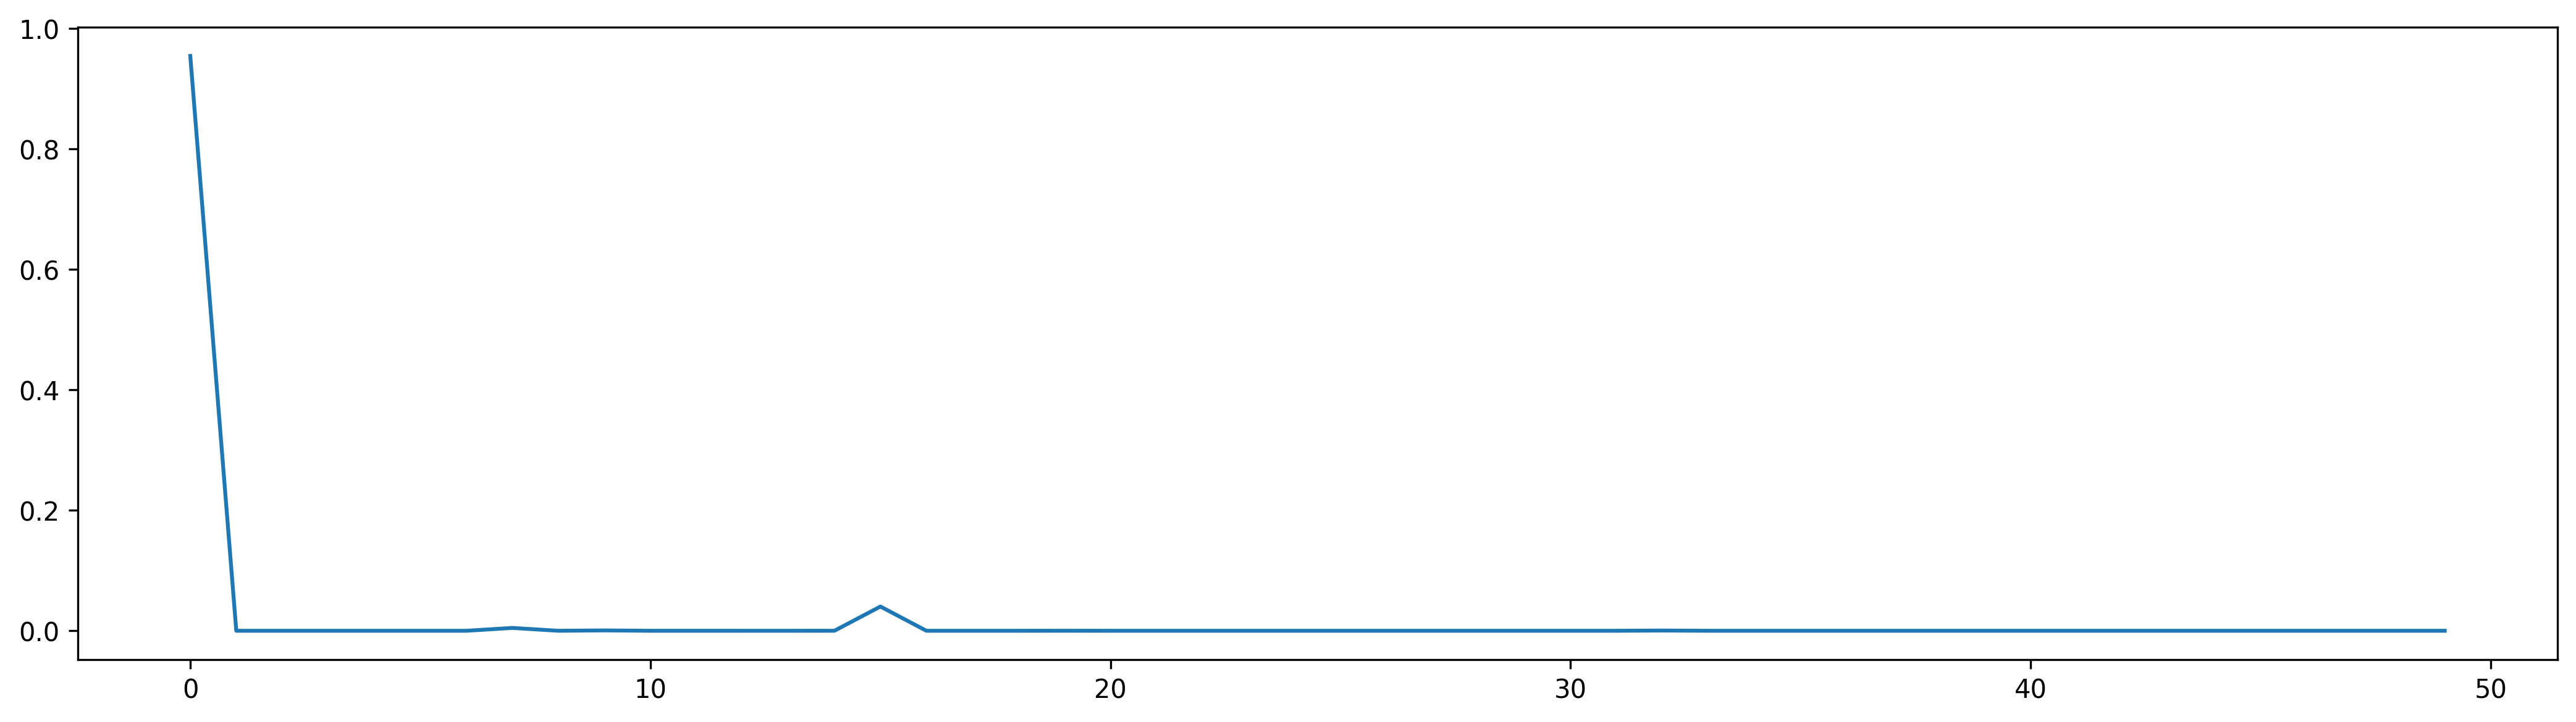

In [72]:
fig = plt.figure(figsize = (14, 4), facecolor = 'white', dpi = 300)

plt.plot(np.arange(0, final_layer_activation.shape[1], 1),
         final_layer_activation[0, :]) # 마지막 layer의 output은 50개의 class로 분류하는 단계
plt.tight_layout()

**각 layer 별로, 모든 필터에 대한 출력값을 한 장의 plot으로 표시**

In [166]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib import colors as mcolors

layer_names = []
for layer in model.layers[:10]:
    layer_names.append(layer.name)

for layer_name, layer_activation in zip(layer_names, activations):
    size = layer_activation.shape[1]
    n_features = layer_activation.shape[-1]
    alpha_list = np.linspace(0, 1, n_features)

    fig = plt.figure(figsize = (10, 6), facecolor = "white", dpi = 300)
    ax = fig.gca(projection = "3d")

    xs = np.arange(size)
    zs = np.arange(n_features)

    cmap = plt.cm.get_cmap('viridis')
    verts = []
    
    for z in zs:
        ys = layer_activation[0, :, z]
        verts.append(list(zip(xs, ys)))

    poly = PolyCollection(verts, facecolors = [cmap(a) for a in alpha_list])
    poly.set_alpha(0.7)

    ax.add_collection3d(poly, zs = zs, zdir = "y")

    ax.set_xlabel('activations')    
    ax.set_ylabel('channels')
    ax.set_zlabel('amplitude')

    ax.set_xlim3d(-1 ,size)
    ax.set_ylim3d(-1, n_features)
    ax.set_zlim3d(np.min(layer_activation[0, :, :]), np.max(layer_activation[0, :, :]))

    plt.title(layer_name)
    plt.tight_layout()
    
    plt.savefig(layer_name + ".png")

Output hidden; open in https://colab.research.google.com to view.